In [19]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow_datasets as tfds
import tensorflow as tf

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Sequential Data

Recurrent Nerual Networks

Variations

Language modelling here ! 



# Sequential Data


# Recurrent neural network

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a sequence (often temporal). This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, language modelling and time series forecasting.

The term *recurrent neural network* is used indiscriminately to refer to two broad classes of networks with a similar general structure, where one is finite impulse (whose impulse response (or response to any finite length input) is of finite duration, because it settles to zero in finite time) and the other is infinite impulse (whose impulse response does not become exactly zero past a certain point, but continues indefinitely). Both classes of networks exhibit temporal dynamic behavior. A finite impulse recurrent network is a directed acyclic graph that can be unrolled and replaced with a strictly feedforward neural network, while an infinite impulse recurrent network is a directed cyclic graph that can not be unrolled.

Both finite impulse and infinite impulse recurrent networks can have additional stored states, and the storage can be under direct control by the neural network. The storage can also be replaced by another network or graph, if that incorporates time delays or has feedback loops. Such controlled states are referred to as gated state or gated memory, and are part of long short-term memory networks (LSTMs) and gated recurrent units. This is also called Feedback Neural Network. In theory RNNs can make use of information in arbitrarily long sequences (which is useful for language models).

## Vanilla RNNs

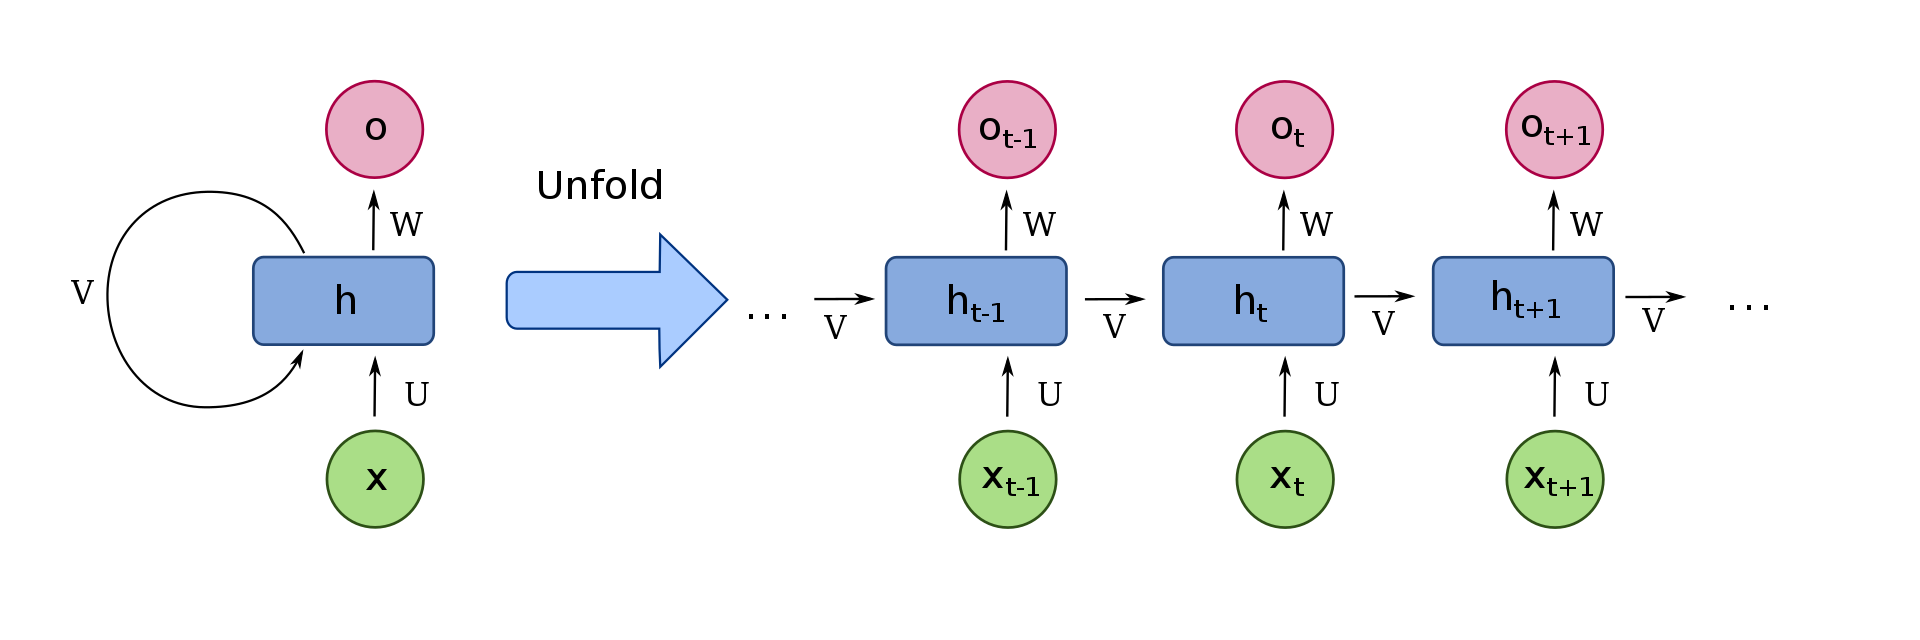
> A recurrent neural network (RNN) and the unfolding in time of the computation involved in its forward computation.

The above image shows a RNN being unrolled (also known as unfolding) into a full network. 
Here unrolling is equiavelent to writing out in full the network for a complete sequence. For instance if we have a sequence of $4$ samples, the network would be unrolled into a $4$-layer dense fully connected neural network, one layer for each sample of interest. This can be expressed as:

$$h_t=\sigma(U x_t + V h_{t-1})$$

Where:
* $x_t$ is the input at time step $t$. For example, $x_1$ could be a sample corresponding to the second sample of the sequence.
* $h_t$ is the hidden state at time step $t$. It is the “memory” of the network. $h_t$ is calculated based on the previous hidden state and the input at the current step: $h_t=\sigma(U x_t + V h_{t-1})$. $h_{-1}$, which is required to calculate the first hidden state, is typically initialized to all zeroes.
* $\sigma$ activation function : usually a non-linearity such as tanh or ReLU.
* $o_t$ is the output at step $t$, here $o_t=h_t$

We can think of the hidden state $h_t$ as the memory of the network, as it captures information about what happened in all the previous time steps. The output at step $o_t$ is calculated solely based on the memory at time $t$. Here a RNN shares the same parameters $(U, V)$ across all steps, this is as we are performing the same operations almost in a *for* loop, just with different inputs. The above diagram shows the two representations for the same RNN *rolled*, we have out output of $o_t$ or *un-rolled* with an output of the sequence of the outputs of the hidden states. Depending on our architecture we may need one form or the other. Similarly, we may not need inputs at each time step. In practice however, it is difficult to access information from many steps
back due to problems like vanishing and exploding gradients, which we discuss shortly.



### RNN from scratch

Lets implement the above in numpy, note that this is a naive implementation, and is only useful to aid understanding


In [20]:
input_features = 1
output_features = 2

U = np.random.random((output_features, input_features))
V = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

inputs = [[1], [2], [3], [4]] # Dim : (sequence_length, input_features)
h_t  = np.zeros((output_features,))

outputs = [] # Dim : (sequence_length, output_features)
for x_t in inputs:
    h_t = np.tanh(np.dot(U, x_t) + np.dot(V, h_t) + b)
    outputs.append(h_t)

print('Output Sequence\n', np.array(outputs)) 

Output Sequence
 [[0.75582339 0.92270988]
 [0.98644211 0.99692686]
 [0.99682389 0.99944992]
 [0.99895519 0.99986996]]


We can see that a RNN is a simple *for* loop the reuses the previous output from the hidden layer during the loop.

# RNN in Keras

A simple RNN (such as the above) is the `tf.keras.layers.SimpleRNN` layer in Keras, which is a fully-connected RNN where the output is to be fed back to input. It takes the regular Keras layer arguments, with a few specific following keyword arguments:
* `units`: Positive integer, dimensionality of the output space.
* `activation`: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `use_bias`: Boolean, (default True), whether the layer uses a bias vector.
* `kernel_initializer`: Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
* `recurrent_initializer`: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
* `bias_initializer`: Initializer for the bias vector. Default: zeros.
* `kernel_regularizer`: Regularizer function applied to the kernel weights matrix. Default: None.
* `recurrent_regularizer`: Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_regularizer`: Regularizer function applied to the bias vector. Default: None.
* `activity_regularizer`: Regularizer function applied to the output of the layer (its "activation"). Default: None.
* `kernel_constraint`: Constraint function applied to the kernel weights matrix. Default: None.
* `recurrent_constraint`: Constraint function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_constraint`: Constraint function applied to the bias vector. Default: None.
* `dropout`: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
* `recurrent_dropout`: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
* `return_sequences`: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False. (This is the same to *unrolling* the outputs, as seen above)
* `return_state`: Boolean. Whether to return the last state in addition to the output. Default: False
* `go_backwards`: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
* `stateful`: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
* `unroll`: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

The difference with hte `SimpleRNN` layer compared to our naive implementation is that its input is a $3D$ tensor, with shape dimensions of `(batch_size, timesteps, features)`.

As indicated above all recurrent layers in Keras can be *rolled* or *un-rolled*, by specifiying the `return_sequences` flag, where *un-rolled* (`return_sequences=True`) outputs the full unrolled outputs at each timestep ($3D$ tensor os size `(batch_size, timesteps, output_features)`) and *rolled* (`return_sequences=False`, default) returns just the last output of the each input sequence ($2D$ tensor of size `(batch_size, output_features)`). 

We can see an example as follows, as a *rolled* RNN:

In [21]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Embedding(20000, 4),
    keras.layers.SimpleRNN(4)
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 4)           80000     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 4)                 36        
Total params: 80,036
Trainable params: 80,036
Non-trainable params: 0
_________________________________________________________________


Or an *un-rolled* RNN

In [22]:
model = keras.models.Sequential([
    keras.layers.Embedding(20000, 4),
    keras.layers.SimpleRNN(4, return_sequences=True)
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 4)           80000     
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, None, 4)           36        
Total params: 80,036
Trainable params: 80,036
Non-trainable params: 0
_________________________________________________________________


We use *un-rolling* to stack RNN ontop of each other, as this allows us to increase the representation power of the network

In [23]:
model = keras.models.Sequential([
    keras.layers.Embedding(20000, 4),
    keras.layers.SimpleRNN(4, return_sequences=True),
    keras.layers.SimpleRNN(4, return_sequences=True),
    keras.layers.SimpleRNN(4,)
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 4)           80000     
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, None, 4)           36        
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, None, 4)           36        
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 4)                 36        
Total params: 80,108
Trainable params: 80,108
Non-trainable params: 0
_________________________________________________________________


## LSTM & GRU Layers

In practice the `SimpleRNN` is not used and instead we use the variations of it of the *LSTM* and *GRU* RNNs. As the `SimpleRNN` finds it very difficult to access information form many steps back due to the problems of *vanishing* and *exploding gradients*. Vanishing gradients being that the gradient for paramter updates will be vanishingly small, effectively preventing the paramters from changing their value and exploding gradietns being the gradients become too large that saturate the activation functions imparing training of the network. To solve the *exploding gradients* we can clip them to small number whenever they explode (via parameters `contraint`s). We can also attempt to solve the *vanishing gradients* here by intilizing the `recurrent_kernel` to start off as a idnetnitify matrix rather than random intilization, and to use `ReLU` units on the output layer (as these have a gradient of either 0 or 1).

# Long short-term memory (LSTM)

Long short-term memory (LSTM) (proposed in 1997) is an RNN adaption that avoids the vanishing gradient problem. LSTM is normally augmented by recurrent gates called “forget gates”. LSTM prevents backpropagated errors from vanishing or exploding as instead, errors can flow backwards through unlimited numbers of virtual layers unfolded in space. That is, the LSTM can learn tasks that require memories of events that happened thousands or even millions of discrete time steps earlier. LSTM works even given long delays between significant events and can handle signals that mix low and high frequency components.

Many applications use stacks of LSTM RNNs and train them by *Connectionist Temporal Classification* (CTC) to find an RNN weight matrix that maximizes the probability of the label sequences in a training set, given the corresponding input sequences. CTC achieves both alignment and recognition.

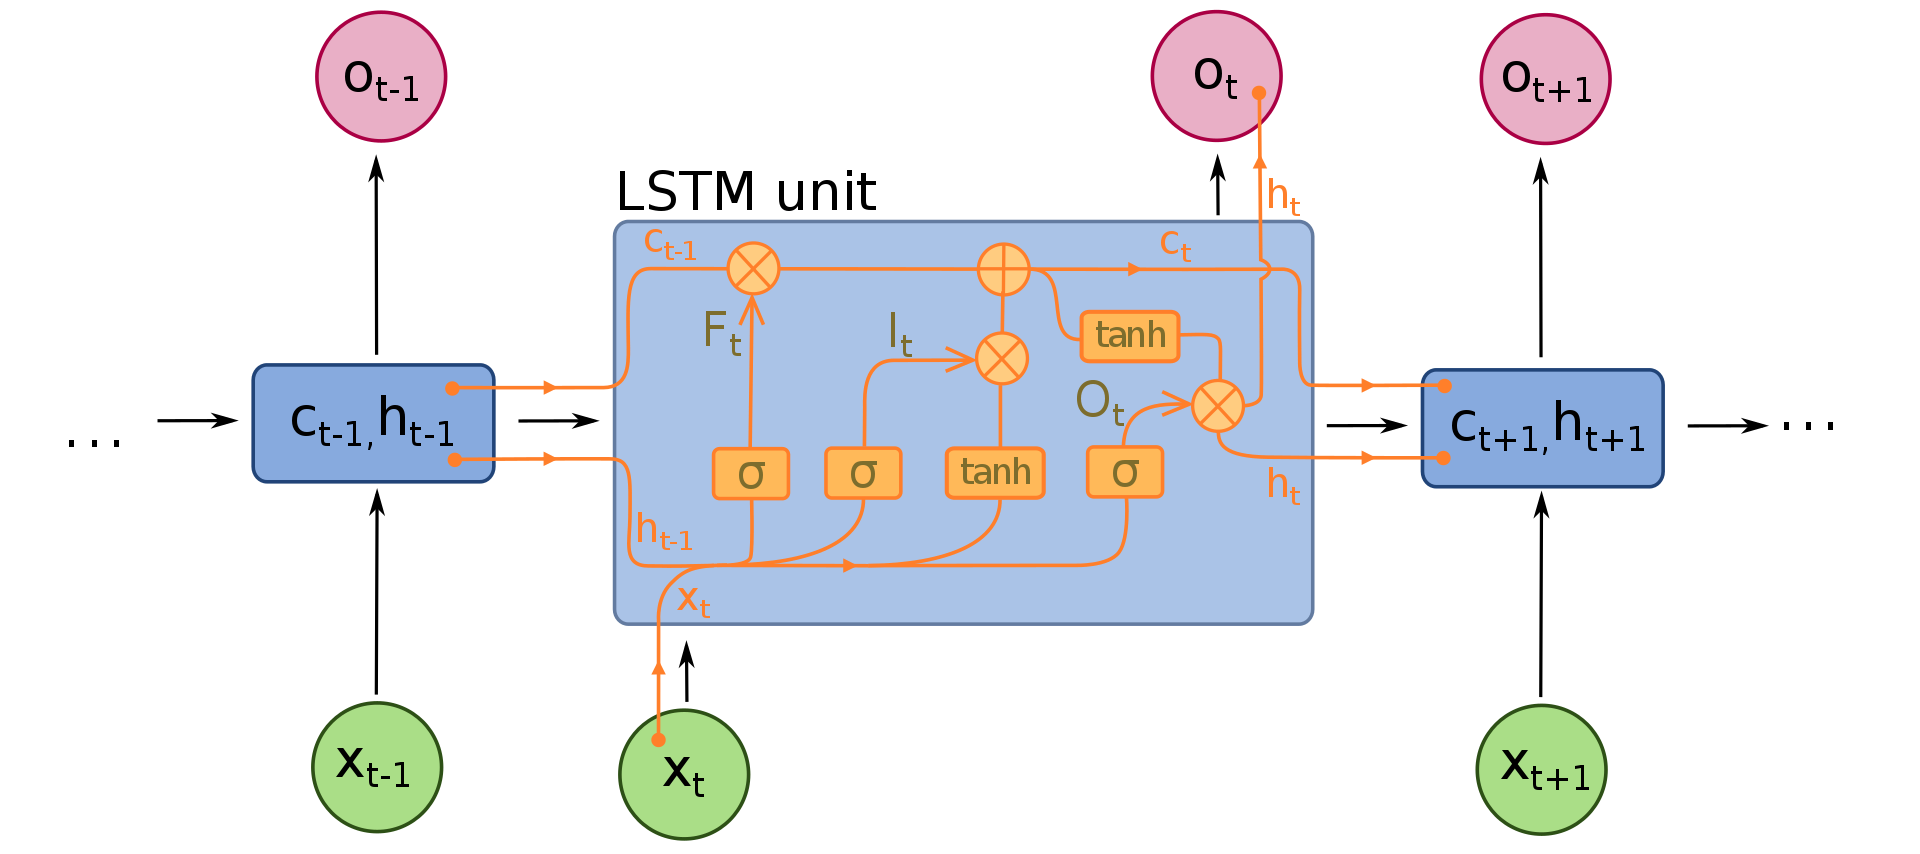

> A Long short-term memory unit unfolded

Represented as :

$$
\begin{align}
&i_t = \sigma_g(W_{i} x_t + U_{i} h_{t-1} + b_i)&\text{(input gate)}&\\
&f_t = \sigma_g(W_{f} x_t + U_{f} h_{t-1} + b_f)&\text{(forget gate)}& \\
&o_t = \sigma_g(W_{o} x_t + U_{o} h_{t-1} + b_o)&\text{(output gate)}& \\
&\tilde{c}_t = \sigma_h(W_{c} x_t + U_{c} h_{t-1} + b_c)&\text{(new memory cell)}& \\
&c_t = f_t \circ c_{t-1} + i_t \circ \tilde{c}_t&\text{(final memory cell)}& \\
&h_t = o_t \circ \sigma_h(c_t)&&
\end{align}
$$

where the initial values are $c_0 = 0$ and $h_0 = 0$ and the operator $\circ$ denotes the Hadamard product (element-wise product). The subscript $t$ indexes the time step. It's variables are:

* $x_t \in \mathbb{R}^{d}$: input vector to the LSTM unit
* $f_t \in \mathbb{R}^{h}$: forget gate's activation vector
* $i_t \in \mathbb{R}^{h}$: input/update gate's activation vector
* $o_t \in \mathbb{R}^{h}$: output gate's activation vector
* $h_t \in \mathbb{R}^{h}$: hidden state vector also known as output vector of the LSTM unit
*$\tilde{c}_t \in \mathbb{R}^{h}$: cell input activation vector
*$c_t \in \mathbb{R}^{h}$: cell state vector
*$W \in \mathbb{R}^{h \times d}$, $U \in \mathbb{R}^{h \times h} $ and $b \in \mathbb{R}^{h}$: weight matrices and bias vector parameters which need to be learned during training

where the superscripts $d$ and $h$ refer to the number of input features and number of hidden units, respectively. And activation functions are:

* $\sigma_g$: (Activation function, sigmoid function)
* $\sigma_c$: tanh
* $\sigma_h$: tanh

We can load this layer in Keras as `tf.keras.layers.LSTM`, we have to set the `units` of hidden layers, and then we have the following optional keyword arguments:
* `units` : Positive integer, dimensionality of the output space.
* `activation` : Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `recurrent_activation` : Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `use_bias` : Boolean (default True), whether the layer uses a bias vector.
* `kernel_initializer` : Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
* `recurrent_initializer` : Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
* `bias_initializer` : Initializer for the bias vector. Default: zeros.
* `unit_forget_bias` : Boolean (default True). If True, add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". This is * `recommended`  in Jozefowicz et al..
* `kernel_regularizer` : Regularizer function applied to the kernel weights matrix. Default: None.
* `recurrent_regularizer` : Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_regularizer` : Regularizer function applied to the bias vector. Default: None.
* `activity_regularizer` : Regularizer function applied to the output of the layer (its "activation"). Default: None.
* `kernel_constraint` : Constraint function applied to the kernel weights matrix. Default: None.
* `recurrent_constraint` : Constraint function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_constraint` : Constraint function applied to the bias vector. Default: None.
* `dropout` : Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
* `recurrent_dropout` : Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
* `implementation` : Implementation mode, either 1 or 2. Mode 1 will structure its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them * `into`  fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications. Default: 2.
* `return_sequences` : Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.
* `return_state` : Boolean. Whether to return the last state in addition to the output. Default: False.
* `go_backwards` : Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
* `stateful` : Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
* `time_major` : The shape format of the inputs and outputs tensors. If True, the inputs and outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [* `batch` , timesteps, feature]. Using time_major = True is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. However, most TensorFlow * `data`  is batch-major, so by default this function accepts input and emits output in batch-major form.
* `unroll` : Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.


# Gated recurrent unit

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014. The GRU is like a long short-term memory (LSTM) with forget gate but has fewer parameters than LSTM, as it lacks an output gate. GRU's performance on certain tasks of polyphonic music modeling and speech signal modeling was found to be similar to that of LSTM. GRUs have been shown to exhibit even better performance on certain smaller datasets.

However, as shown by Gail Weiss & Yoav Goldberg & Eran Yahav, the LSTM is "strictly stronger" than the GRU as it can easily perform unbounded counting, while the GRU cannot. 

Similarly, as shown by Denny Britz & Anna Goldie & Minh-Thang Luong & Quoc Le of Google Brain, LSTM cells consistently outperform GRU cells in "the first large-scale analysis of architecture variations for Neural Machine Translation."

They do have the benefit they have fewer parameters they are quicker to train and use for predictions, however in practice it is best to use a LSTM is possible.

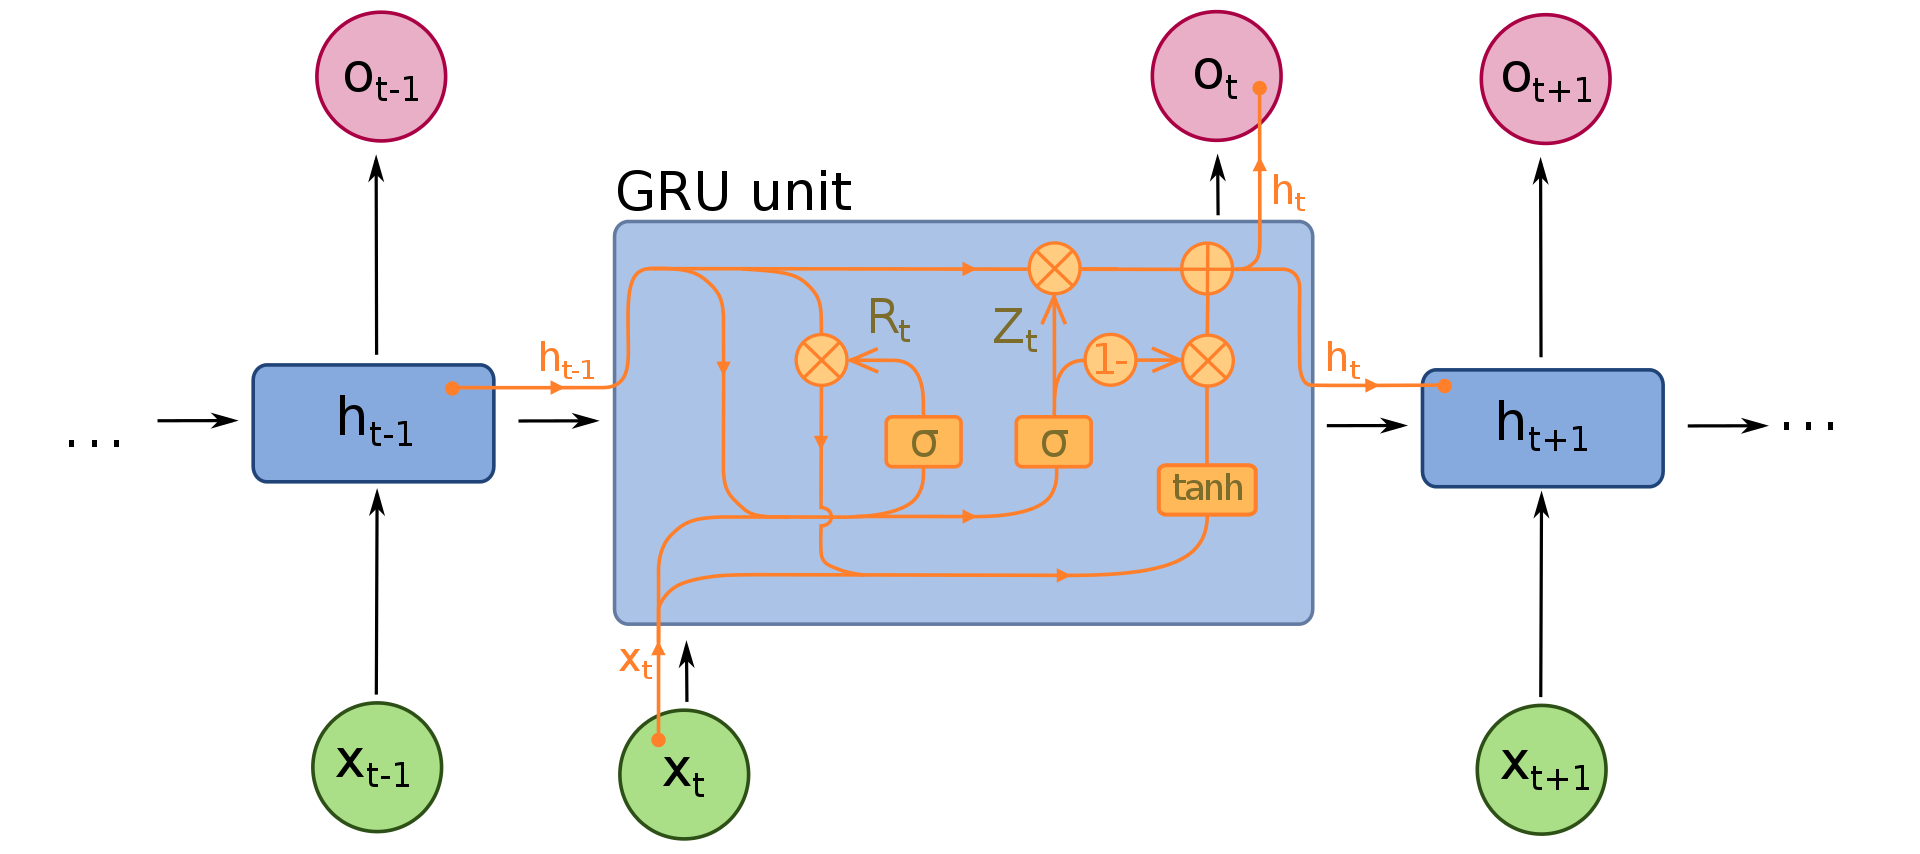

> Gated recurrent unit unfolded

Represented as initially, for $t = 0$, the output vector is $h_0 = 0$. 

$$
\begin{align}
z_t &= \sigma_g(W_{z} x_t + U_{z} h_{t-1} + b_z) \\
r_t &= \sigma_g(W_{r} x_t + U_{r} h_{t-1} + b_r) \\
h_t &=  z_t \odot h_{t-1} + (1 - z_t)  \odot \phi_h(W_{h} x_t + U_{h} (r_t \odot h_{t-1}) + b_h)
\end{align}
$$

Variables
* $x_t$: input vector
* $h_t$: output vector
* $z_t$: update gate vector
* $r_t$: reset gate vector
* $W$, $U$ and $b$: parameter matrices and vector

Activation functions:
* $\sigma_g$: sigmoid function
*$\phi_h$: tanh

We can load this layer in Keras as `tf.keras.layers.GRU`, we have to set the `units` of hidden layers, and then we have the following optional keyword arguments:
* `units` : Positive integer, dimensionality of the output space.
* `activation` : Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `recurrent_activation` : Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `use_bias` : Boolean, (default True), whether the layer uses a bias vector.
* `kernel_initializer` : Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
* `recurrent_initializer` : Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
* `bias_initializer` : Initializer for the bias vector. Default: zeros.
* `kernel_regularizer` : Regularizer function applied to the kernel weights matrix. Default: None.
* `recurrent_regularizer` : Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_regularizer` : Regularizer function applied to the bias vector. Default: None.
* `activity_regularizer` : Regularizer function applied to the output of the layer (its "activation"). Default: None.
* `kernel_constraint` : Constraint function applied to the kernel weights matrix. Default: None.
* `recurrent_constraint` : Constraint function applied to the recurrent_kernel weights matrix. Default: None.
* `bias_constraint` : Constraint function applied to the bias vector. Default: None.
* `dropout` : Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
* `recurrent_dropout` : Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
* `implementation` : Implementation mode, either 1 or 2. Mode 1 will structure its operations as a larger number of smaller dot products and additions, whereas mode 2 will batch them into fewer, larger operations. These modes will have different performance profiles on different hardware and for different applications. Default: 2.
* `return_sequences` : Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
* `return_state` : Boolean. Whether to return the last state in addition to the output. Default: False.
* `go_backwards` : Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
* `stateful` : Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
* `unroll` : Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.
* `time_major` : The shape format of the inputs and outputs tensors. If True, the inputs and outputs will be in shape [timesteps, batch, feature], whereas in the False case, it will be [batch, timesteps, feature]. Using time_major = True is a bit more efficient because it avoids transposes at the beginning and end of the RNN calculation. However, most TensorFlow data is batch-major, so by default this function accepts input and emits output in batch-major form.
* `reset_after` : GRU convention (whether to apply reset gate after or before matrix multiplication). False = "before", True = "after" (default and CuDNN compatible).

# LSTM Example

Lets create a text classifier, by training a LSTM based model on the IMDB large movie review dataset for sentiment analysis.

In [24]:
# Load the pre-processed IMDB large movie review dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']
encoder = info.features['text'].encoder
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

Epoch 1/10
    118/Unknown - 71s 605ms/step - loss: 0.7096 - accuracy: 0.4967

KeyboardInterrupt: 